## IMPORTS and UTILS

In [ ]:
print("hi")

import os, math
import pandas as pd
import subprocess
import re
import numpy as np
import json
import csv

from joblib import Parallel, delayed



import matplotlib.pyplot as plt
import seaborn as sns


import os

from scripts import combat_info
from scripts import combat_quick_apply
from scripts import combat_quick_QC
from robust_evaluation_tools.robust_utils import get_site, robust_text, rwp_text, get_camcan_file, get_diseases, get_metrics, add_nb_patients_and_diseased
from robust_evaluation_tools.robust_harmonization import fit, apply, visualize_harmonization, QC, compare_with_compilation, create_presentation, compare_distances, compare_with_compilation_var
from robust_evaluation_tools.synthectic_sites_generations import generate_sites
from robust_evaluation_tools.robust_outlier_detection import z_score_detection, flag_sid

MAINFOLDER = "RESULTS/MAE_TEST"
SYNTHETIC_SITES = f"{MAINFOLDER}/SYNTHETIC_SITES"

ANALYSIS_FOLDER = f"{MAINFOLDER}/ANALYSIS"

robust_methods_for_analysis = ["No","raw", "IQR",'MAD','MMS', 'VS', 'VS2', 'FLIP', 'Z_SCORE']

## HARMONIZATION

## EXECUTOR

In [ ]:
harmonization_method= "classic"

SYNTHETIC_SITES_VERSION = "v1"

metrics = get_metrics()
#diseases = get_diseases(True)
diseases = ["SCHZ", "AD"]
robust_methods = ["IQR",'MAD','MMS', 'VS', 'VS2', 'FLIP', 'Z_SCORE']
#robust_methods = ["MMS","IQR",'MAD', 'VS', 'VS2', 'TOP30', 'FLIP']
#'Z_SCORE'


sample_sizes = [100]  # Différentes tailles d'échantillon
disease_ratios = [0.03, 0.1, 0.3, 0.5]  # Différents pourcentages de malades
num_tests = 15  # Nombre de tests à effectuer pour chaque combinaison
n_jobs=-1

# for disease in diseases:
#     generate_sites_for_disease(
#         disease, SYNTHETIC_SITES, SYNTHETIC_SITES_VERSION, sample_sizes, disease_ratios, num_tests, n_jobs
#     )

In [ ]:
def load_mae_or_maev_compilations(mainfolder, diseases, sample_sizes, disease_ratios, num_tests, mae_or_maev='mae'):
    tests, trains = [], []
    for d in diseases:
        for s in sample_sizes:
            for r in disease_ratios:
                for i in range(num_tests):
                    base = os.path.join(mainfolder, "PROCESS", d, f"{s}_{int(r*100)}", str(i))
                    test_path  = os.path.join(base, f"{mae_or_maev}_compilation_test.csv")
                    train_path = os.path.join(base, f"{mae_or_maev}_compilation_train.csv")
                    if os.path.isfile(test_path):
                        tests.append(pd.read_csv(test_path))
                    if os.path.isfile(train_path):
                        trains.append(pd.read_csv(train_path))
    df_test  = pd.concat(tests,  ignore_index=True) if tests  else pd.DataFrame()
    df_train = pd.concat(trains, ignore_index=True) if trains else pd.DataFrame()
    return df_test, df_train

In [ ]:
# Load all files into a dictionary
mae_compilations = {}
for file_name in ["mae_compilation_test_global.csv", "mae_compilation_train_global.csv"]:
    file_path = os.path.join(MAINFOLDER, file_name)
    if os.path.exists(file_path):
        mae_compilations[file_name] = pd.read_csv(file_path)
    else:
        mae_or_maev = 'mae' if 'mae' in file_name else 'maev'
        df_test, df_train = load_mae_or_maev_compilations(
            MAINFOLDER, diseases, sample_sizes, disease_ratios, num_tests, mae_or_maev=mae_or_maev
        )
        mae_compilations[file_name] = df_test if 'test' in file_name else df_train

# Process each file
for file_name, mae_compilation in mae_compilations.items():
    # Retrieve unique methods
    methods = mae_compilation['robust_method'].unique()

    # Save a CSV file for each method
    for method in methods:
        # Filter rows corresponding to the method
        method_df = mae_compilation[mae_compilation['robust_method'] == method]
        
        # Create a folder for the method
        method_directory = os.path.join(MAINFOLDER, 'CSV', method)
        os.makedirs(method_directory, exist_ok=True)
        
        # Save the CSV file in the folder
        method_file_path = os.path.join(method_directory, f"{method}_{file_name}")
        method_df.to_csv(method_file_path, index=False)

In [ ]:
# Load all files into a dictionary
maev_compilations = {}
for file_name in ["maev_compilation_test_global.csv", "maev_compilation_train_global.csv"]:
    file_path = os.path.join(MAINFOLDER, file_name)
    if os.path.exists(file_path):
        maev_compilations[file_name] = pd.read_csv(file_path)
    else:
        mae_or_maev = 'maev' if 'maev' in file_name else 'mae'
        df_test, df_train = load_mae_or_maev_compilations(
            MAINFOLDER, diseases, sample_sizes, disease_ratios, num_tests, mae_or_maev=mae_or_maev
        )
        maev_compilations[file_name] = df_test if 'test' in file_name else df_train

# Process each file
for file_name, maev_compilation in maev_compilations.items():
    # Retrieve unique methods
    methods = maev_compilation['robust_method'].unique()

    # Save a CSV file for each method
    for method in methods:
        # Filter rows corresponding to the method
        method_df = maev_compilation[maev_compilation['robust_method'] == method]
        
        # Create a folder for the method
        method_directory = os.path.join(MAINFOLDER, 'CSV', method)
        os.makedirs(method_directory, exist_ok=True)
        
        # Save the CSV file in the folder
        method_file_path = os.path.join(method_directory, f"{method}_{file_name}")
        method_df.to_csv(method_file_path, index=False)

In [ ]:
def gather_all_method_files(main_folder, methods, context="test"):
    all_dfs = []
    for m in methods:
        file_name = f"{m}_mae_compilation_{context}_global.csv"
        path = os.path.join(main_folder,'CSV', m, file_name)
        if os.path.exists(path):
            df = pd.read_csv(path)
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

In [ ]:
def gather_all_method_files_maev(main_folder, methods, context="test"):
    all_dfs = []
    for m in methods:
        file_name = f"{m}_maev_compilation_{context}_global.csv"
        path = os.path.join(main_folder,'CSV', m, file_name)
        if os.path.exists(path):
            df = pd.read_csv(path)
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

In [ ]:
def transformer_df_large_en_long(df_large):

    context_cols = ["site", "method", "robust_method", "disease", "metric"]
    bundle_cols = [col for col in df_large.columns if col not in context_cols]

    df_long = df_large.melt(
        id_vars=context_cols,
        value_vars=bundle_cols,
        var_name="bundle",
        value_name="mae"
    )
    df_long.loc[df_long['robust_method'] == 'No', 'robust_method'] = df_long.loc[df_long['robust_method'] == 'No', 'method']


    return df_long

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

EPS     = 1e-3   # ### MOD: seuil « HC‑close »
TARGET  = 0.95   # ### MOD: 95 % du gain réalisable = « atteint HC »

# 🔁 Fonction principale pour traiter une combinaison (site, disease)
def analyser_combinaison(df_subset, site, disease, save=False, output_dir=None):
    # ─────────────────────────────────────────────────────────────
    # 1) Format long + pivot
    # ─────────────────────────────────────────────────────────────
    df_subset = transformer_df_large_en_long(df_subset)
    pivot = df_subset.pivot_table(
        index=["metric", "bundle"],
        columns="robust_method",         # ta colonne
        values="mae"
    )

    if "NoRobust" not in pivot.columns or "hc" not in pivot.columns:
        print(f"⚠️ Données incomplètes pour {site} - {disease}, sautées.")
        return

    methods_to_compare = [m for m in pivot.columns if m not in ["NoRobust", "hc"]]

    # ─────────────────────────────────────────────────────────────
    # 2) Ancienne métrique : Δ% vs NoRobust  (on la garde)
    # ─────────────────────────────────────────────────────────────
    legacy_rows = []
    for method in methods_to_compare:
        delta = 100 * (pivot["NoRobust"] - pivot[method]) / pivot["NoRobust"]
        improved  = delta > 0
        worsened  = (pivot[method] > pivot["NoRobust"]) & (pivot["hc"] < pivot["NoRobust"])
        legacy_rows.append({
            "method": method,
            "% improved": improved.mean()*100,
            "% worsened (inacc.)": worsened.mean()*100,
            "mean gain (%)":  delta[improved].mean(),
            "mean loss (%)":  delta[worsened].mean(),
            "worst loss (%)": delta[worsened].min()
        })
    legacy_df = pd.DataFrame(legacy_rows)

    # ─────────────────────────────────────────────────────────────
    # 3) Nouvelle métrique : « portion de gain capturé »
    # ─────────────────────────────────────────────────────────────
    E0      = pivot["NoRobust"]
    Estar   = pivot["hc"]
    dmax    = E0 - Estar
    hc_close = dmax.abs() < EPS

    score_rows = []
    scores_dict = {}
    for method in methods_to_compare:
        Em = pivot[method]
        score = 1 - (Em - Estar) / dmax
        score[hc_close] = np.nan                     # ignore HC‑close
        scores_dict[method] = score                  # pour les boxplots
        score_rows.append({
            "method": method,
            "% HC‑reach (≥95 %)": (score >= TARGET).mean()*100,
            "% fail (<0)":        (score < 0).mean()*100,
            "score mean":         score.mean(),
            "score median":       score.median(),
            "score min":          score.min()
        })
    score_df = pd.DataFrame(score_rows)

    # ─────────────────────────────────────────────────────────────
    # 4) Affichage / sauvegarde des deux tableaux
    # ─────────────────────────────────────────────────────────────
    print(f"\n=== {site} - {disease} : anciens indicateurs ===")
    print(legacy_df.round(2))
    print(f"\n=== {site} - {disease} : nouveaux indicateurs ===")
    print(score_df.round(2))

    if save:
        os.makedirs(output_dir, exist_ok=True)
        legacy_df.to_csv(os.path.join(output_dir, f"legacy_{site}_{disease}.csv"), index=False)
        score_df.to_csv (os.path.join(output_dir, f"score_{site}_{disease}.csv"),  index=False)

    # ─────────────────────────────────────────────────────────────
    # 5) Boxplots des **scores** par métrique (nouvelle échelle)
    # ─────────────────────────────────────────────────────────────
    metrics = df_subset["metric"].unique()
    fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        if metric not in pivot.index.get_level_values(0):
            ax.set_visible(False)
            continue
        # récupère les séries de scores pour ce metric
        data_metric = [scores_dict[m].loc[metric].dropna() for m in methods_to_compare]
        sns.boxplot(data=data_metric, ax=ax)
        ax.set_title(metric)
        ax.set_xticklabels(methods_to_compare, rotation=45)
        ax.axhline(1, ls="--", color="grey", lw=0.7)           # ### MOD: ligne 1 = HC

    plt.suptitle(f"Score = portion de gain capturé – {site}, {disease}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save:
        plt.savefig(os.path.join(output_dir, f"boxplot_{site}_{disease}.png"), dpi=300)
        plt.close()
    else:
        plt.show()


## ANALYSIS


=== Résumé 100_patients_10_percent_0 - AD ===
    method  % improved  % worsened (inacceptable)  mean gain (%)  \
0     FLIP   64.651163                  24.651163      31.407204   
1      IQR   56.279070                  31.395349      23.559891   
2      MAD   59.302326                  28.139535      19.286580   
3      MMS   69.069767                  19.767442      17.154600   
4       VS   69.302326                  19.767442      18.796645   
5      VS2   61.860465                  25.348837      19.051171   
6  Z_SCORE   75.348837                  12.790698      26.388786   

   mean loss (%)  worst loss (%)  
0     -21.915603      -75.364326  
1     -19.252576     -211.276368  
2      -8.641390      -48.991591  
3     -33.563371     -308.682855  
4     -32.044368     -243.795833  
5     -58.758500     -416.543382  
6     -23.634546      -87.286195  


UnboundLocalError: local variable 'boxprops' referenced before assignment

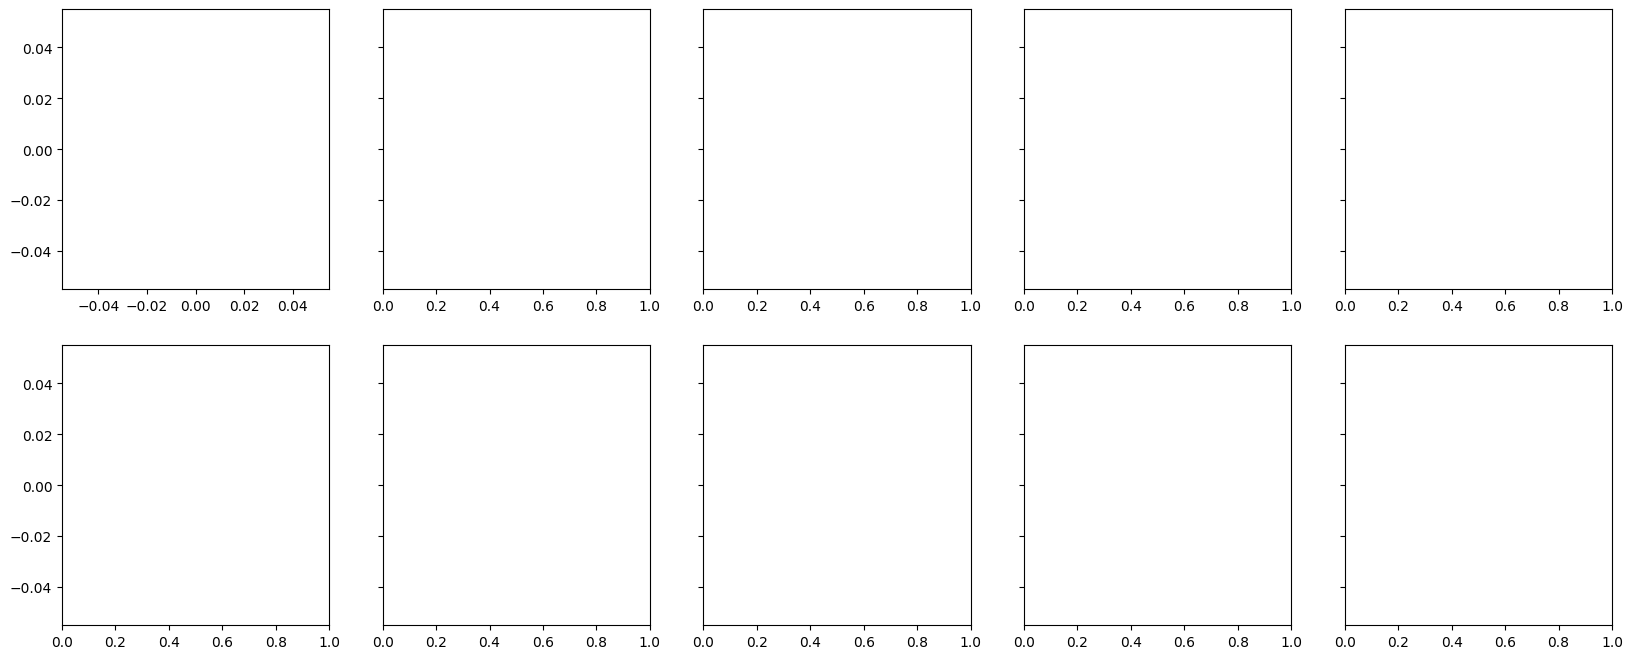

In [11]:


# 🟢 Charge ton DataFrame
df = gather_all_method_files(MAINFOLDER, robust_methods_for_analysis, "train")
df = df[df["method"] != "robust_rwp"]
df = df[df["method"] != "raw"]

# 📂 Répertoire de sortie (optionnel)
output_dir = os.path.join(ANALYSIS_FOLDER, "PERFORMANCE")
os.makedirs(output_dir, exist_ok=True)


# 🔁 Itérer sur toutes les combinaisons (site, disease)
for (site, disease), subset in df.groupby(["site", "disease"]):
    analyser_combinaison(subset, site, disease, save=False, output_dir=output_dir)  # mets `save=True` si tu veux des fichiers